In [1]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

#import tensorflow as tf
#from keras.utils.np_utils import to_categorical
#from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

random.seed(100)

In [2]:
image_dir = "/scratch/xxsi3290/Kaggle/jpeg/jpeg/"

In [3]:
dicom_data = pd.read_csv('/scratch/xxsi3290/Kaggle/dicom_info.csv')
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [4]:
dicom_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [5]:
# check image types in dataset
dicom_data.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [6]:
meta_data = pd.read_csv('/scratch/xxsi3290/Kaggle/meta.csv')
meta_data.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [7]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6775 entries, 0 to 6774
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SeriesInstanceUID  6775 non-null   object
 1   StudyInstanceUID   6775 non-null   object
 2   Modality           6775 non-null   object
 3   SeriesDescription  6775 non-null   object
 4   BodyPartExamined   6775 non-null   object
 5   SeriesNumber       6775 non-null   int64 
 6   Collection         6775 non-null   object
 7   Visibility         6775 non-null   int64 
 8   ImageCount         6775 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 476.5+ KB


In [8]:
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [9]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [10]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [11]:
#cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg/', image_dir, regex=True))
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg/', image_dir, regex=True)
#cropped_images.head()

full_mammogram_images = full_mammogram_images.replace('CBIS-DDSM/jpeg/', image_dir, regex=True)
#full_mammogram_images.head()

ROI_mask_images = ROI_mask_images.replace('CBIS-DDSM/jpeg/', image_dir, regex=True)
#ROI_mask_images.head()

# view new paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammogram_images.iloc[0])
print('ROI Mask Images paths:\n')
print(ROI_mask_images.iloc[0])

Cropped Images paths:

/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [12]:
# organize image paths
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammogram_images:
    key = dicom.split("/")[6]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[6]
    cropped_images_dict[key] = dicom
for dicom in ROI_mask_images:
    key = dicom.split("/")[6]
    roi_img_dict[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

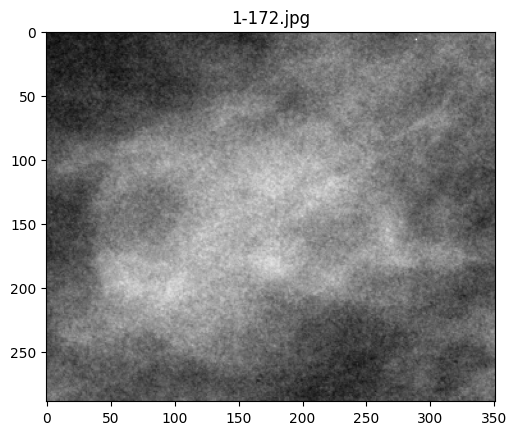

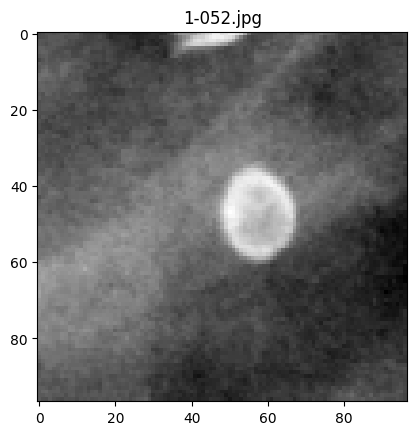

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/1-034.jpg


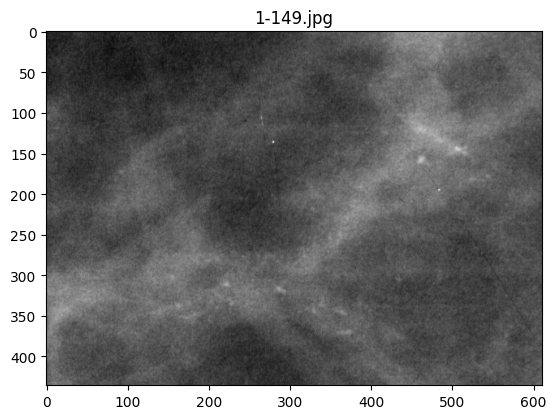

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/1-003.jpg
File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/1-085.jpg


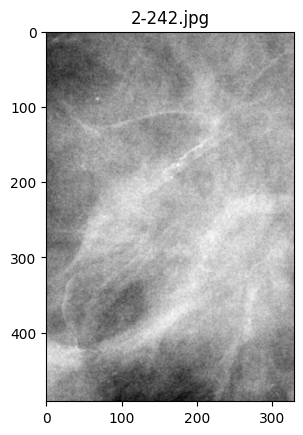

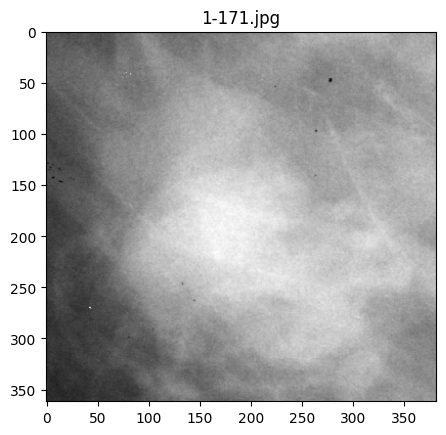

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281604745510897859806968805740602385667/1-111.jpg


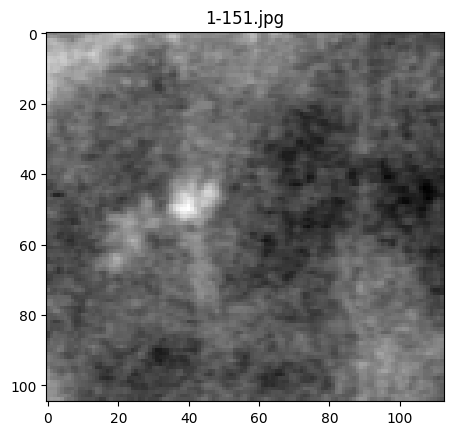

In [13]:
import matplotlib.pyplot as plt 
import glob
import PIL
import random

for file in cropped_images[0:10]:
    try:
        if not os.path.exists(file):
            print(f"File not found: {file}")
            continue  # Skip to the next file
        cropped_images_show = PIL.Image.open(file)
        gray_img = cropped_images_show.convert("L")
        plt.imshow(gray_img, cmap='gray')
        plt.title(os.path.basename(file))
        plt.show()
    except Exception as e:
        print(f"Error loading {file}: {e}")
        continue

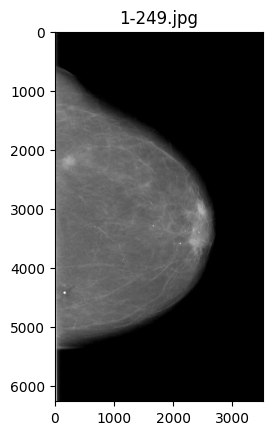

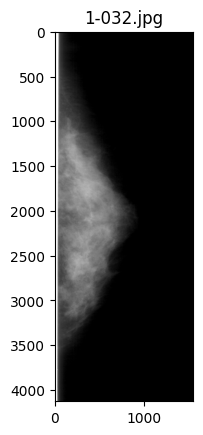

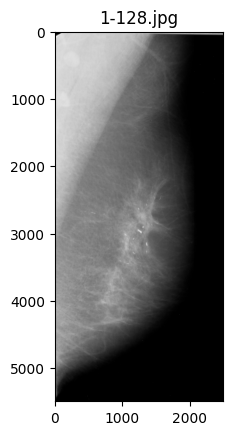

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74956658311383957201426978750903861062/1-248.jpg


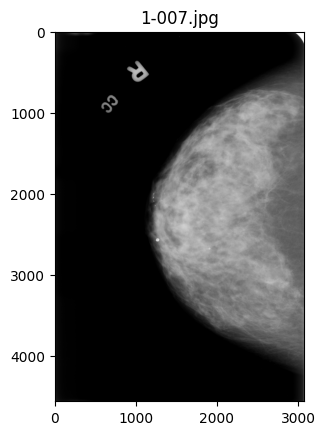

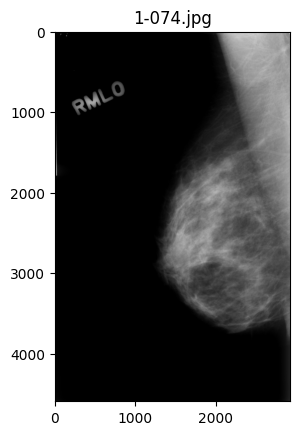

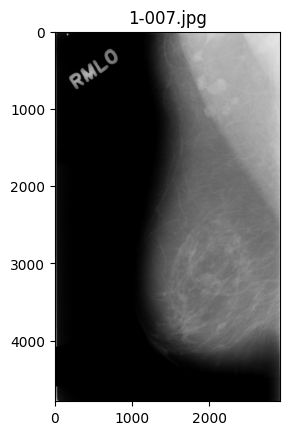

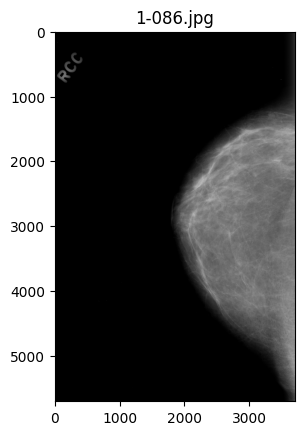

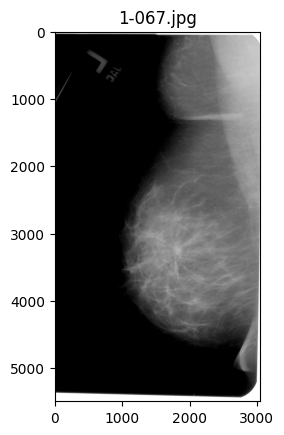

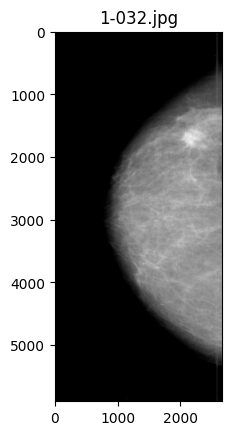

In [14]:
import os
import PIL
import matplotlib.pyplot as plt

for file  in full_mammogram_images[0:10]:
    try:
        if not os.path.exists(file):
            print(f"File not found: {file}")
            continue
        full_mammogram_images_show = PIL.Image.open(file)
        gray_img= full_mammogram_images_show.convert("L")
        plt.imshow(gray_img, cmap='gray')
        plt.title(os.path.basename(file))
        plt.show()
    except Exception as e:
        print(f"Error loading {file}: {e}")
        continue

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


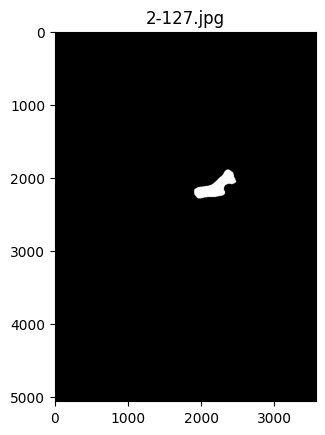

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/2-281.jpg
File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/2-086.jpg


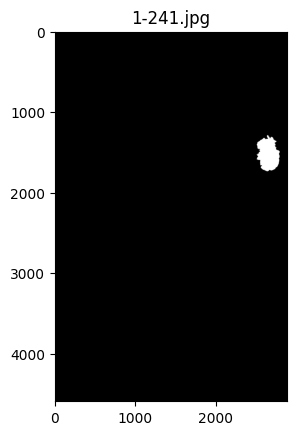

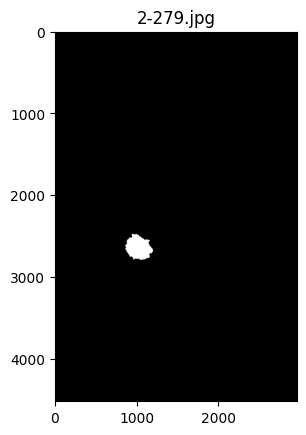

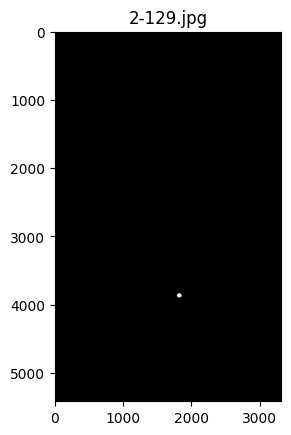

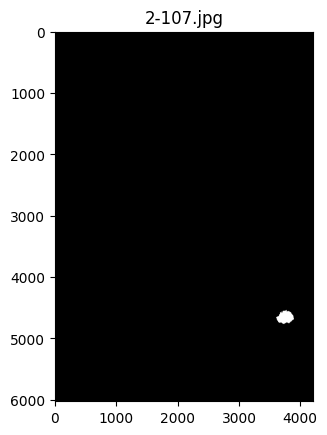

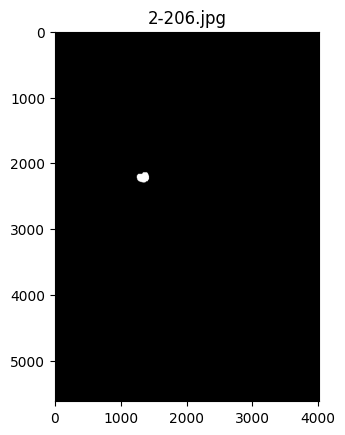

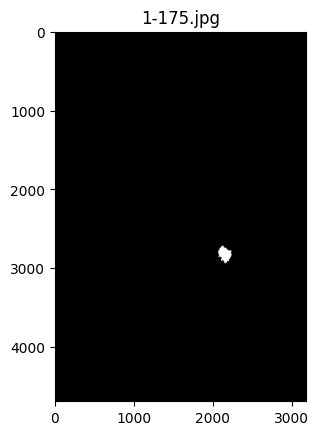

In [15]:
import os
import PIL
import matplotlib.pyplot as plt

for file in ROI_mask_images[0:10]:
    try:
        if not os.path.exists(file):  
            print(f"File not found: {file}")
            continue
        ROI_mask_images_show = PIL.Image.open(file)
        gray_img = ROI_mask_images_show.convert("L")
        plt.imshow(gray_img, cmap='gray')
        plt.title(os.path.basename(file))
        plt.show()
    except Exception as e:
        print(f"Error loading {file}: {e}")
        continue


In [16]:
calc_train_df = pd.read_csv('/scratch/xxsi3290/Kaggle/calc_case_description_train_set.csv')
calc_test_df = pd.read_csv('/scratch/xxsi3290/Kaggle/calc_case_description_test_set.csv')

calc_train_df.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [17]:
def fix_image_path_calc(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammo_dict:
            dataset.iloc[i, 11] = full_mammo_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_images_dict:
            dataset.iloc[i, 12] = cropped_images_dict[img_name]
        
        img_name = img[13].split("/")[2]
        if img_name in roi_img_dict:
            dataset.iloc[i, 13] = roi_img_dict[img_name]

fix_image_path_calc(calc_train_df)
fix_image_path_calc(calc_test_df)

In [18]:
# check unique values in pathology column
calc_train_df.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [19]:
mass_train_df = pd.read_csv('/scratch/xxsi3290/Kaggle/mass_case_description_train_set.csv')
mass_test_df = pd.read_csv('/scratch/xxsi3290/Kaggle/mass_case_description_test_set.csv')

mass_train_df.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [20]:
def fix_image_path_mass(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammo_dict:
            dataset.iloc[i, 11] = full_mammo_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_images_dict:
            dataset.iloc[i, 12] = cropped_images_dict[img_name]
        
        img_name = img[13].split("/")[2]
        if img_name in roi_img_dict:
            dataset.iloc[i, 13] = roi_img_dict[img_name]

fix_image_path_mass(mass_train_df)
fix_image_path_mass(mass_test_df)

In [21]:
mass_train_df.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [22]:
mass_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [23]:
# rename columns
mass_train_df = mass_train_df.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train_df.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...


In [24]:
# check for null values
mass_train_df.isnull().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64

In [25]:
# fill in missing values using the backwards fill method
mass_train_df['mass_shape'] = mass_train_df['mass_shape'].bfill()
mass_train_df['mass_margins'] = mass_train_df['mass_margins'].bfill()

#check null values
mass_train_df.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [26]:
# quantitative summary of features
mass_train_df.describe()

,breast_density,abnormality_id,assessment,subtlety
count,1318.000000,1318.000000,1318.000000,1318.000000
mean,2.203338,1.116085,3.504552,3.965857
std,0.873774,0.467013,1.414609,1.102032
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,3.000000
50%,2.000000,1.000000,4.000000,4.000000
75%,3.000000,1.000000,4.000000,5.000000
max,4.000000,6.000000,5.000000,5.000000


In [27]:
# view mass_test
mass_test_df.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...,/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...


In [28]:
# check datasets shape
print(f'Shape of mass_train: {mass_train_df.shape}')
print(f'Shape of mass_test: {mass_test_df.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [29]:
mass_test_df.isnull().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  0
mass margins               17
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [30]:
mass_test_df = mass_test_df.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

In [31]:
# fill in missing values using the backwards fill method
mass_test_df['mass_margins'] = mass_test_df['mass_margins'].bfill()

#check null values
mass_test_df.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [32]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

# create function to display images
def display_images(column, number):
    valid_rows = []

    # First, collect only valid image paths
    for _, row in mass_train_df.iterrows():
        image_path = row[column]
        if os.path.exists(image_path):
            valid_rows.append(row)
        if len(valid_rows) == number:
            break

    # Create subplots
    cols = len(valid_rows)
    fig, axes = plt.subplots(1, cols, figsize=(5 * cols, 5))

    # If only one image is found, axes is not iterable
    if cols == 1:
        axes = [axes]

    # Loop through and display images
    for i, row in enumerate(valid_rows):
        image_path = row[column]
        try:
            image = mpimg.imread(image_path)
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f"{row['pathology']}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            continue

    plt.tight_layout()
    plt.show()


Full Mammograms:



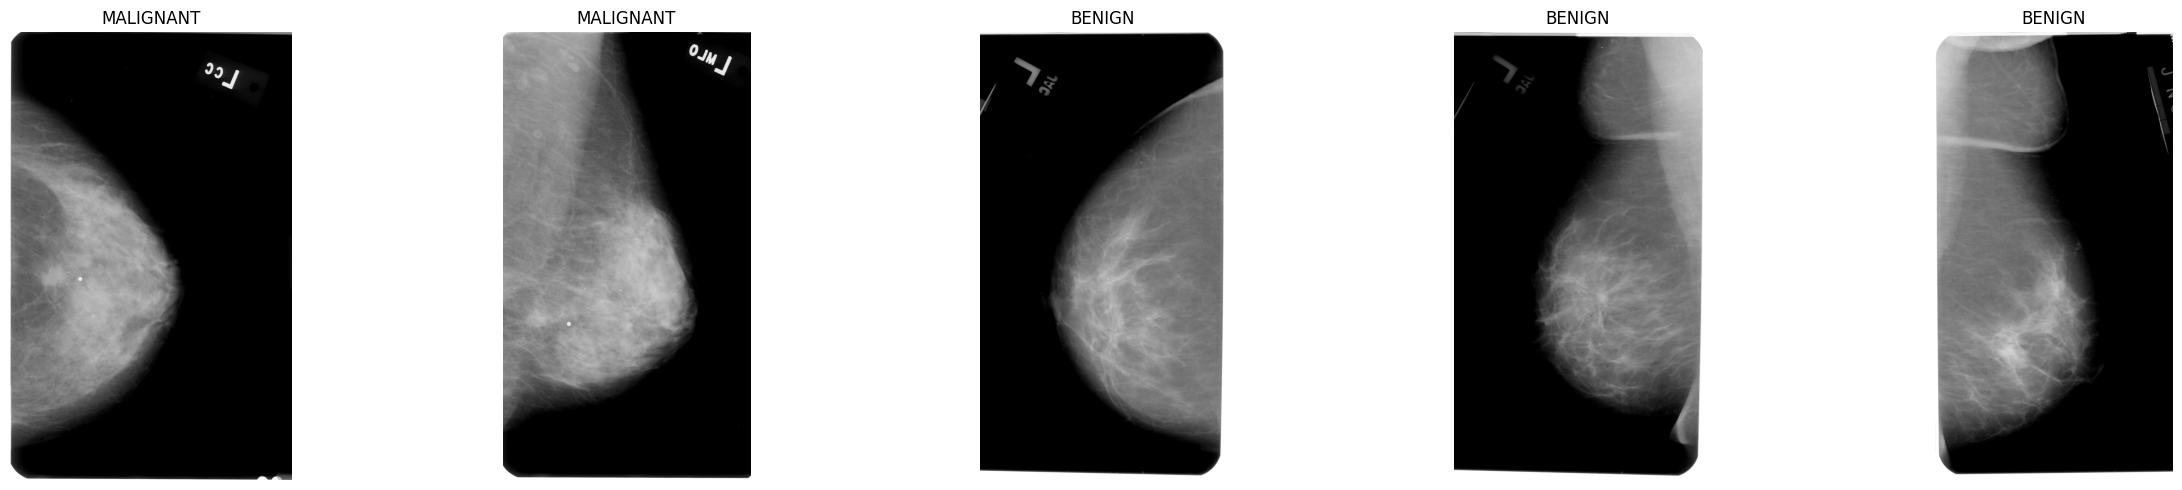

Cropped Mammograms:



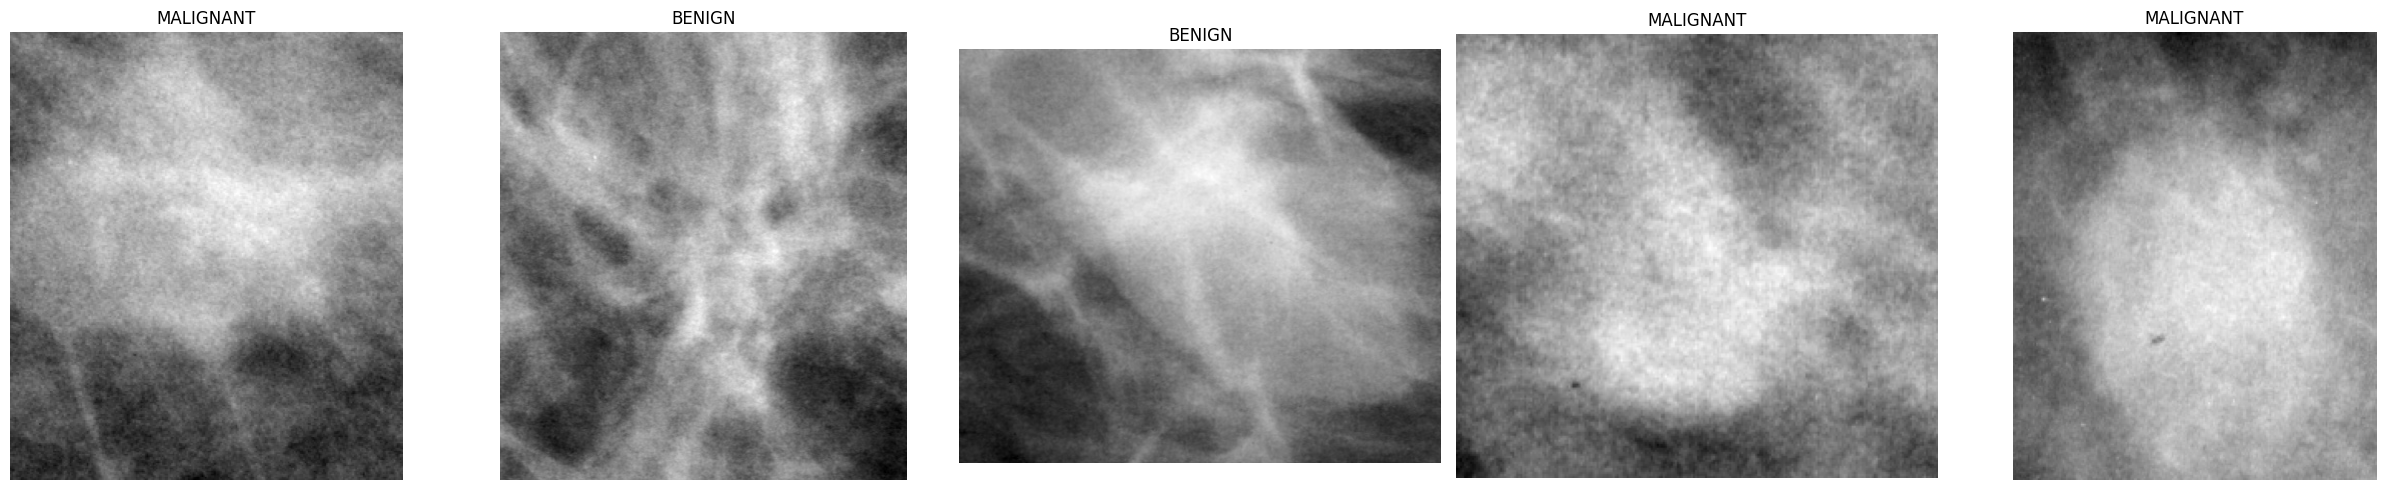

ROI Mask Mammograms:



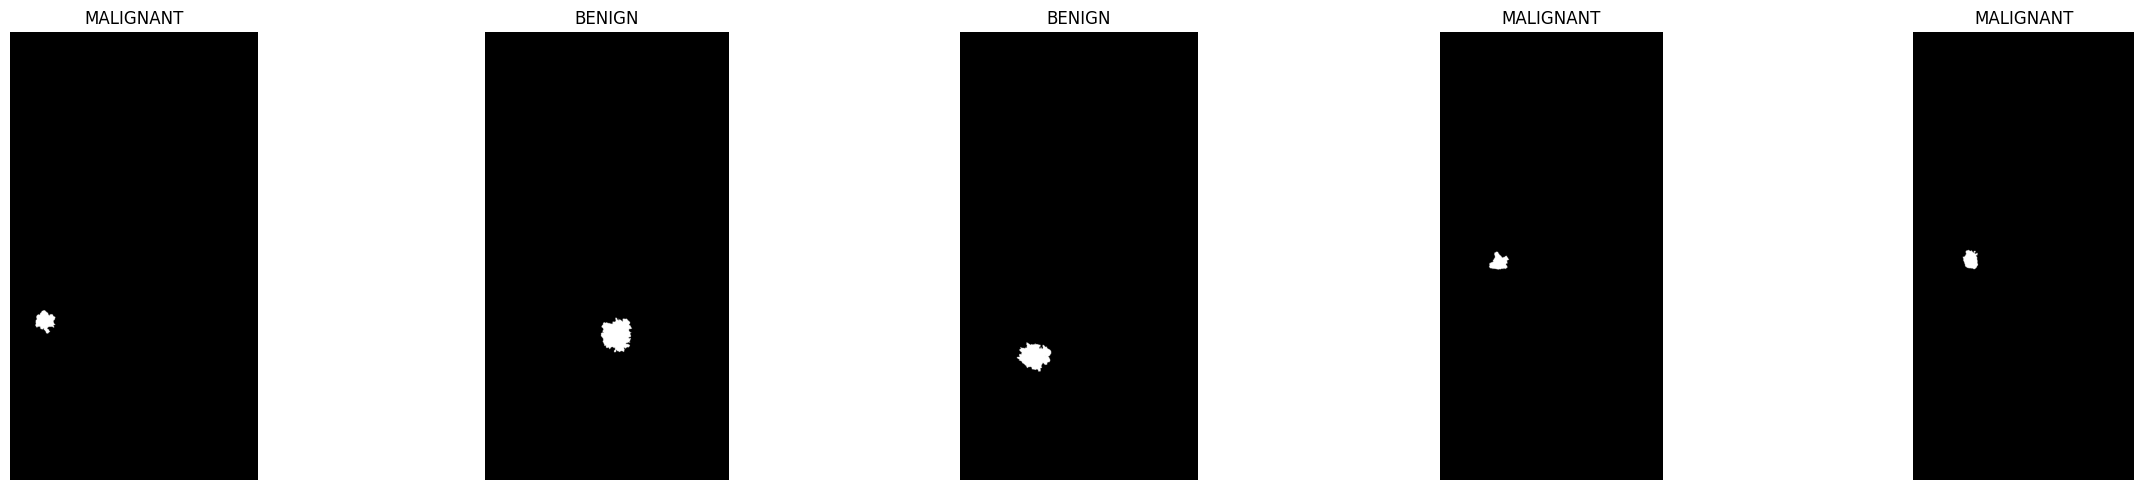

In [33]:
print('Full Mammograms:\n')
display_images('image_file_path', 5)

print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)

print('ROI Mask Mammograms:\n')
display_images('ROI_mask_file_path', 5)


In [34]:
img = cv2.imread("/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175476572912204146233170994160170991797/1-227.jpg")
if img is None:
    print("Failed to load image.")
else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Failed to load image.


[ WARN:0@65.505] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175476572912204146233170994160170991797/1-227.jpg'): can't open/read file: check file path/integrity


In [35]:
path = "/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175476572912204146233170994160170991797/1-227.jpg"
print("Exists?" , os.path.exists(path))

Exists? False


In [36]:
print("Readable?", os.access(path, os.R_OK))

Readable? False


In [37]:
import os

directory = "/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175476572912204146233170994160170991797/"
if os.path.exists(directory):
    print(os.listdir(directory))
else:
    print("Directory does not exist.")

[]


In [38]:
import glob

results = glob.glob("/scratch/xxsi3290/Kaggle/jpeg/**/1-227.jpg", recursive=True)
print(results)

['/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.110047623311234531315180497121049893055/1-227.jpg', '/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127852344812675202120951809370187154227/1-227.jpg', '/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16797291711280675438259327020908841485/1-227.jpg', '/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.171692011112195764922046481164189381263/1-227.jpg', '/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181641695812444595204610303252231825517/1-227.jpg', '/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.207222801913295076440202482321306809609/1-227.jpg', '/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.232655664111867764900916015764258363014/1-227.jpg', '/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.238013703212709404511871026300597771897/1-227.jpg', '/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.24485293117580516132853571239539238

In [39]:
from tensorflow.keras.utils import to_categorical
# Import necessary TensorFlow libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, Dropout
# from tensorflow.keras.applications.densenet import DenseNet169
import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import warnings

# Suppress all warnings globally
warnings.filterwarnings("ignore")

2025-05-07 15:38:38.996784: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 15:38:39.029622: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
#second preprocessing
def image_processor(image_path, target_size):
    """Preprocess images for CNN model"""
    absolute_image_path = os.path.abspath(image_path)
    #image = cv2.imread(absolute_image_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.imread(absolute_image_path, cv2.IMREAD_GRAYSCALE)

    # Skip unreadable or empty images
    if image is None:
        print(f"⚠️ Skipping unreadable image: {absolute_image_path}")
        return None
    
    # Resize image
    image = cv2.resize(image, (target_size[1], target_size[0]))
    
    # Histogram Equalization
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    #l_channel, a_channel, b_channel = cv2.split(image)
    #clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    #l_channel = clahe.apply(l_channel)
    #image = cv2.merge((l_channel, a_channel, b_channel))
    #image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
    
     #Negative transformation
    #image = 255 - image
    
     #Rescale to [0, 1]
    image = image.astype(np.float32) / 255.0
    
    return image

In [41]:
# Merge datasets
full_mass = pd.concat([mass_train_df, mass_test_df], axis=0)

In [42]:
# Define the target size
target_size = (224, 224, 3)

In [43]:
# Sample a subset of images
sample_size = 1696  # Adjust the sample size as needed
full_mass_sample = full_mass.sample(n=sample_size, random_state=42)

In [44]:
# Apply preprocessor to train data
full_mass_sample['processed_images'] = full_mass_sample['image_file_path'].apply(
    lambda x: image_processor(x, target_size)
)


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175476572912204146233170994160170991797/1-227.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199195778912558713817031507321459770006/1-135.jpg


[ WARN:0@88.278] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175476572912204146233170994160170991797/1-227.jpg'): can't open/read file: check file path/integrity
[ WARN:0@88.420] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199195778912558713817031507321459770006/1-135.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336120486712406273923832111983569913869/1-113.jpg


[ WARN:0@88.524] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336120486712406273923832111983569913869/1-113.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180869746613853192241744905213634425726/1-281.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.235220303613128401917357295780294851812/1-186.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.258122848711932114229110145764023097059/1-085.jpg


[ WARN:0@88.826] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180869746613853192241744905213634425726/1-281.jpg'): can't open/read file: check file path/integrity
[ WARN:0@88.951] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.235220303613128401917357295780294851812/1-186.jpg'): can't open/read file: check file path/integrity
[ WARN:0@89.016] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.258122848711932114229110145764023097059/1-085.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174014585211651496903314748162396558249/1-258.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19175306412221051336720162903880247165/1-065.jpg


[ WARN:0@89.055] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174014585211651496903314748162396558249/1-258.jpg'): can't open/read file: check file path/integrity
[ WARN:0@89.055] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19175306412221051336720162903880247165/1-065.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.117454129112394095421646199292904617412/1-105.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16311307713420957612660499721513179515/1-262.jpg


[ WARN:0@89.315] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.117454129112394095421646199292904617412/1-105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@89.470] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16311307713420957612660499721513179515/1-262.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.128110220510263998502063254390605854196/1-054.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.417738311511512636014376396132371802556/1-038.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.171166015912754582622813408142073790722/1-096.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334704328611391643805508991083300190349/1-108.jpg


[ WARN:0@89.873] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.128110220510263998502063254390605854196/1-054.jpg'): can't open/read file: check file path/integrity
[ WARN:0@89.873] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.417738311511512636014376396132371802556/1-038.jpg'): can't open/read file: check file path/integrity
[ WARN:0@90.010] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg'): can't open/read file: check file path/integrity
[ WARN:0@90.010] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.171166015912754582622813408142073790722/1-096.jpg'): can't open/read file: check file path/integrity
[ WARN:0@90.010] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1

⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.269090020912271881612869996851061481178/1-265.jpg


[ WARN:0@90.074] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.269090020912271881612869996851061481178/1-265.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.397197585712576980835218625502162434719/1-026.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.154058962613328519929136864181603772657/1-205.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17179439612364242913491828612897592599/1-075.jpg


[ WARN:0@90.337] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.397197585712576980835218625502162434719/1-026.jpg'): can't open/read file: check file path/integrity
[ WARN:0@90.486] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.154058962613328519929136864181603772657/1-205.jpg'): can't open/read file: check file path/integrity
[ WARN:0@90.520] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17179439612364242913491828612897592599/1-075.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403824995113685855926042098451429311853/1-259.jpg


[ WARN:0@90.962] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403824995113685855926042098451429311853/1-259.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.293359047911187270714650133994167840030/1-181.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.263918199211476516622099513693475115311/1-190.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.162585879813814097935228732511788537826/1-119.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.321571514713247316135159699532641256508/1-215.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.83748848211897641311753926793600384304/1-117.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.388721083313285222217770141913502774487/1-233.jpg


[ WARN:0@91.203] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.293359047911187270714650133994167840030/1-181.jpg'): can't open/read file: check file path/integrity
[ WARN:0@91.203] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.263918199211476516622099513693475115311/1-190.jpg'): can't open/read file: check file path/integrity
[ WARN:0@91.232] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.162585879813814097935228732511788537826/1-119.jpg'): can't open/read file: check file path/integrity
[ WARN:0@91.233] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.321571514713247316135159699532641256508/1-215.jpg'): can't open/read file: check file path/integrity
[ WARN:0@91.311] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1

⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.242629471012127869529548965622673332057/1-258.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52911228912044066036741669740519618759/1-054.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.9383151312430789908711205212663448581/1-243.jpg


[ WARN:0@91.423] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.242629471012127869529548965622673332057/1-258.jpg'): can't open/read file: check file path/integrity
[ WARN:0@91.424] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52911228912044066036741669740519618759/1-054.jpg'): can't open/read file: check file path/integrity
[ WARN:0@91.620] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.9383151312430789908711205212663448581/1-243.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158760583312396940802790127503023485498/1-099.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.290229220113810647235081932003928413427/1-046.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280437157711493692000884645494047094463/1-130.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283896293710468565409445671813981066945/1-033.jpg


[ WARN:0@91.800] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158760583312396940802790127503023485498/1-099.jpg'): can't open/read file: check file path/integrity
[ WARN:0@91.801] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.290229220113810647235081932003928413427/1-046.jpg'): can't open/read file: check file path/integrity
[ WARN:0@91.801] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280437157711493692000884645494047094463/1-130.jpg'): can't open/read file: check file path/integrity
[ WARN:0@91.976] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283896293710468565409445671813981066945/1-033.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.8345832613913482803966749762437997260/1-017.jpg


[ WARN:0@92.136] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.8345832613913482803966749762437997260/1-017.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.232043140012455442340816109393409527243/1-168.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69102481911614345738992761764104656383/1-112.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57356823611525636036904521060745035167/1-236.jpg


[ WARN:0@92.791] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.232043140012455442340816109393409527243/1-168.jpg'): can't open/read file: check file path/integrity
[ WARN:0@92.817] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69102481911614345738992761764104656383/1-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@92.917] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57356823611525636036904521060745035167/1-236.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.270615391512904438603136029871346997827/1-180.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304645495911706483111438481251619390979/1-117.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.162995550512107573002420048841033718661/1-115.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.70876162012018497914376684992676851191/1-181.jpg


[ WARN:0@93.180] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.270615391512904438603136029871346997827/1-180.jpg'): can't open/read file: check file path/integrity
[ WARN:0@93.180] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304645495911706483111438481251619390979/1-117.jpg'): can't open/read file: check file path/integrity
[ WARN:0@93.332] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.162995550512107573002420048841033718661/1-115.jpg'): can't open/read file: check file path/integrity
[ WARN:0@93.333] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.70876162012018497914376684992676851191/1-181.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74118182511203115438320774433815814204/1-054.jpg


[ WARN:0@93.388] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74118182511203115438320774433815814204/1-054.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149772059212195203914176201483014915047/1-158.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.234810835612633355538815031322259010855/1-061.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.188171322412490158916861741203390183722/1-215.jpg


[ WARN:0@93.800] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149772059212195203914176201483014915047/1-158.jpg'): can't open/read file: check file path/integrity
[ WARN:0@93.986] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.234810835612633355538815031322259010855/1-061.jpg'): can't open/read file: check file path/integrity
[ WARN:0@93.986] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.188171322412490158916861741203390183722/1-215.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.8846141612920489319812758360158257270/1-050.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.109231371313746091407897394002747255810/1-090.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145489058813789765335170389942387615556/1-040.jpg


[ WARN:0@94.055] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.8846141612920489319812758360158257270/1-050.jpg'): can't open/read file: check file path/integrity
[ WARN:0@94.138] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.109231371313746091407897394002747255810/1-090.jpg'): can't open/read file: check file path/integrity
[ WARN:0@94.189] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145489058813789765335170389942387615556/1-040.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78684859813284664039916578740172712994/1-069.jpg


[ WARN:0@94.358] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78684859813284664039916578740172712994/1-069.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345140832810160378520078721331878282316/1-105.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.417608135813097018923712441772099200133/1-167.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.357895865312935232740791412752491722139/1-273.jpg


[ WARN:0@94.570] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345140832810160378520078721331878282316/1-105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@94.632] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.417608135813097018923712441772099200133/1-167.jpg'): can't open/read file: check file path/integrity
[ WARN:0@94.668] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.357895865312935232740791412752491722139/1-273.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69745952012889155812092274262822416242/1-097.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.303187804912710561742283155760426369730/1-239.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.245550762511135550738178630953626561752/1-283.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113107599413757334715056198522480123157/1-223.jpg


[ WARN:0@94.944] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69745952012889155812092274262822416242/1-097.jpg'): can't open/read file: check file path/integrity
[ WARN:0@95.007] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.303187804912710561742283155760426369730/1-239.jpg'): can't open/read file: check file path/integrity
[ WARN:0@95.007] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.245550762511135550738178630953626561752/1-283.jpg'): can't open/read file: check file path/integrity
[ WARN:0@95.135] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113107599413757334715056198522480123157/1-223.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172386840512013560230074211023706864061/1-077.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158164935212165043120376357330832910201/1-177.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.371739864613089761719883355291307551226/1-046.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.246326421513862106416389991742169179906/1-107.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.30946803412446097718909326270548961243/1-153.jpg


[ WARN:0@95.277] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172386840512013560230074211023706864061/1-077.jpg'): can't open/read file: check file path/integrity
[ WARN:0@95.277] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158164935212165043120376357330832910201/1-177.jpg'): can't open/read file: check file path/integrity
[ WARN:0@95.367] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.371739864613089761719883355291307551226/1-046.jpg'): can't open/read file: check file path/integrity
[ WARN:0@95.429] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.246326421513862106416389991742169179906/1-107.jpg'): can't open/read file: check file path/integrity
[ WARN:0@95.429] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1

⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.67409892012207587532711656111341914913/1-113.jpg


[ WARN:0@95.497] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.67409892012207587532711656111341914913/1-113.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12669257310082858042663169390086466638/1-014.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.216808559312941034119240923160831351862/1-272.jpg


[ WARN:0@95.725] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12669257310082858042663169390086466638/1-014.jpg'): can't open/read file: check file path/integrity
[ WARN:0@95.808] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.216808559312941034119240923160831351862/1-272.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.201240665512195560313953074353682854284/1-122.jpg


[ WARN:0@95.985] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.201240665512195560313953074353682854284/1-122.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419780045811507010327582708564022857860/1-299.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.288980828511203708511066530843699446563/1-225.jpg


[ WARN:0@96.444] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419780045811507010327582708564022857860/1-299.jpg'): can't open/read file: check file path/integrity
[ WARN:0@96.444] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.288980828511203708511066530843699446563/1-225.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44065475811569696824006401280610368950/1-228.jpg


[ WARN:0@97.364] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44065475811569696824006401280610368950/1-228.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.151746203711583824325790496232356555781/1-133.jpg


[ WARN:0@97.602] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.151746203711583824325790496232356555781/1-133.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325293736011893421816901315930122472763/1-183.jpg


[ WARN:0@97.912] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325293736011893421816901315930122472763/1-183.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54848434312309044100463325442088001375/1-148.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.33507760912554145902744111920344485171/1-235.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.191684932212508771025952925500117559600/1-118.jpg


[ WARN:0@98.337] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54848434312309044100463325442088001375/1-148.jpg'): can't open/read file: check file path/integrity
[ WARN:0@98.377] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.33507760912554145902744111920344485171/1-235.jpg'): can't open/read file: check file path/integrity
[ WARN:0@98.525] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.191684932212508771025952925500117559600/1-118.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.200394253511150032912987268422492919749/1-191.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149183380211624614428278537532778083640/1-178.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.370020768811676220424047464123530592133/1-204.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.416023076012080833905740875610727249164/1-196.jpg


[ WARN:0@98.581] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.200394253511150032912987268422492919749/1-191.jpg'): can't open/read file: check file path/integrity
[ WARN:0@98.663] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149183380211624614428278537532778083640/1-178.jpg'): can't open/read file: check file path/integrity
[ WARN:0@98.663] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.370020768811676220424047464123530592133/1-204.jpg'): can't open/read file: check file path/integrity
[ WARN:0@98.693] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.416023076012080833905740875610727249164/1-196.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175043772610570804328930190413021504082/1-133.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.395806490413060973910077403213561423281/1-097.jpg


[ WARN:0@98.955] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175043772610570804328930190413021504082/1-133.jpg'): can't open/read file: check file path/integrity
[ WARN:0@99.121] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.395806490413060973910077403213561423281/1-097.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95066275112816836637397827910274893726/1-298.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.208612233610863139028646317134220626037/1-021.jpg


[ WARN:0@99.330] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95066275112816836637397827910274893726/1-298.jpg'): can't open/read file: check file path/integrity
[ WARN:0@99.472] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.208612233610863139028646317134220626037/1-021.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg


[ WARN:0@99.547] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.125012772811929054738373917960770689523/1-273.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.141690078312425196829711709851898133059/1-195.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.311879772413692509211401737020929176955/1-177.jpg


[ WARN:0@99.999] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.125012772811929054738373917960770689523/1-273.jpg'): can't open/read file: check file path/integrity
[ WARN:0@100.120] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.141690078312425196829711709851898133059/1-195.jpg'): can't open/read file: check file path/integrity
[ WARN:0@100.120] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.311879772413692509211401737020929176955/1-177.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.231418499611483562804956443353410908413/1-012.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.227359829311782247437660996313591134165/1-265.jpg


[ WARN:0@100.221] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.231418499611483562804956443353410908413/1-012.jpg'): can't open/read file: check file path/integrity
[ WARN:0@100.258] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.227359829311782247437660996313591134165/1-265.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241213639112627717226706279733585932152/1-003.jpg


[ WARN:0@100.718] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241213639112627717226706279733585932152/1-003.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95930514311143196521379851620797527375/1-133.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.272184723711385047630954095450427972031/1-184.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.83882081811707961806397341681542038535/1-198.jpg


[ WARN:0@101.048] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95930514311143196521379851620797527375/1-133.jpg'): can't open/read file: check file path/integrity
[ WARN:0@101.048] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.272184723711385047630954095450427972031/1-184.jpg'): can't open/read file: check file path/integrity
[ WARN:0@101.146] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.83882081811707961806397341681542038535/1-198.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.223355501110410477409262071651794035858/1-060.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.120465669611268291509420478952677521038/1-173.jpg


[ WARN:0@101.387] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.223355501110410477409262071651794035858/1-060.jpg'): can't open/read file: check file path/integrity
[ WARN:0@101.518] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.120465669611268291509420478952677521038/1-173.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85686461910787171020983218554121150052/1-291.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175043772610570804328930190413021504082/1-133.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.265953197912973660327069359641506533925/1-288.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100632214012866120117337678502539182046/1-075.jpg


[ WARN:0@101.988] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85686461910787171020983218554121150052/1-291.jpg'): can't open/read file: check file path/integrity
[ WARN:0@101.988] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175043772610570804328930190413021504082/1-133.jpg'): can't open/read file: check file path/integrity
[ WARN:0@102.136] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.265953197912973660327069359641506533925/1-288.jpg'): can't open/read file: check file path/integrity
[ WARN:0@102.137] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100632214012866120117337678502539182046/1-075.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95066275112816836637397827910274893726/1-298.jpg


[ WARN:0@102.240] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95066275112816836637397827910274893726/1-298.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.55307148413799814332579214442886195340/1-298.jpg


[ WARN:0@102.474] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.55307148413799814332579214442886195340/1-298.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.219607249012903142628057639991148226306/1-072.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.36825032713107530300938213160028717974/1-270.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg


[ WARN:0@102.720] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.219607249012903142628057639991148226306/1-072.jpg'): can't open/read file: check file path/integrity
[ WARN:0@102.720] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.36825032713107530300938213160028717974/1-270.jpg'): can't open/read file: check file path/integrity
[ WARN:0@102.838] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.138854373111438727811729486684128233341/1-172.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.1147559510416701110684356293737205301/1-079.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59887648512379053809277845872128232362/1-106.jpg


[ WARN:0@103.072] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.138854373111438727811729486684128233341/1-172.jpg'): can't open/read file: check file path/integrity
[ WARN:0@103.072] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.1147559510416701110684356293737205301/1-079.jpg'): can't open/read file: check file path/integrity
[ WARN:0@103.175] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59887648512379053809277845872128232362/1-106.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328977677511962475112321192060403830590/1-242.jpg


[ WARN:0@103.390] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328977677511962475112321192060403830590/1-242.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194084118912652164632677195583265936023/1-190.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.176964796612485740037787572680731561117/1-077.jpg


[ WARN:0@103.601] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194084118912652164632677195583265936023/1-190.jpg'): can't open/read file: check file path/integrity
[ WARN:0@103.668] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.176964796612485740037787572680731561117/1-077.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.349504173712862535704286567751526799904/1-020.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100522676511025180541602449080267145647/1-111.jpg


[ WARN:0@103.805] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.349504173712862535704286567751526799904/1-020.jpg'): can't open/read file: check file path/integrity
[ WARN:0@103.833] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100522676511025180541602449080267145647/1-111.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172787227312499793236059621232382095130/1-267.jpg


[ WARN:0@104.397] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172787227312499793236059621232382095130/1-267.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.313320260312335825215652094932408846389/1-089.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.62593965512657640623373713153873390284/1-129.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.28994390011193705314585586210966915731/1-163.jpg


[ WARN:0@104.767] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.313320260312335825215652094932408846389/1-089.jpg'): can't open/read file: check file path/integrity
[ WARN:0@104.789] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg'): can't open/read file: check file path/integrity
[ WARN:0@104.934] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.62593965512657640623373713153873390284/1-129.jpg'): can't open/read file: check file path/integrity
[ WARN:0@104.964] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.28994390011193705314585586210966915731/1-163.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317213562911173877740615561593769151663/1-037.jpg


[ WARN:0@105.167] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317213562911173877740615561593769151663/1-037.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361510015512526913136413449054168104152/1-230.jpg


[ WARN:0@105.449] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361510015512526913136413449054168104152/1-230.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.56526196612878022942647118353975254976/1-017.jpg


[ WARN:0@105.730] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.56526196612878022942647118353975254976/1-017.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.382912580213452264934816946051837938528/1-036.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46228080811339703822182406561482041808/1-085.jpg


[ WARN:0@105.938] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.382912580213452264934816946051837938528/1-036.jpg'): can't open/read file: check file path/integrity
[ WARN:0@106.014] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46228080811339703822182406561482041808/1-085.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27953444711693870518443009471767038842/1-179.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.364070243511921550101340386794199125508/1-107.jpg


[ WARN:0@106.431] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27953444711693870518443009471767038842/1-179.jpg'): can't open/read file: check file path/integrity
[ WARN:0@106.594] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.364070243511921550101340386794199125508/1-107.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.273104176312975794115853377520445198068/1-149.jpg


[ WARN:0@107.102] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg'): can't open/read file: check file path/integrity
[ WARN:0@107.102] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.273104176312975794115853377520445198068/1-149.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403835121912715843000196868400248684588/1-104.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95930514311143196521379851620797527375/1-133.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139051271411881139019982240242711370769/1-061.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.4258120910410897428422437754132883711/1-109.jpg


[ WARN:0@107.337] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403835121912715843000196868400248684588/1-104.jpg'): can't open/read file: check file path/integrity
[ WARN:0@107.337] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg'): can't open/read file: check file path/integrity
[ WARN:0@107.454] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95930514311143196521379851620797527375/1-133.jpg'): can't open/read file: check file path/integrity
[ WARN:0@107.500] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139051271411881139019982240242711370769/1-061.jpg'): can't open/read file: check file path/integrity
[ WARN:0@107.527] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1

⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281986553811315949820316643132362105669/1-198.jpg


[ WARN:0@107.587] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281986553811315949820316643132362105669/1-198.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385754322612458255422314848630057330699/1-274.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.374524690313732405614119264610057663073/1-035.jpg


[ WARN:0@108.045] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385754322612458255422314848630057330699/1-274.jpg'): can't open/read file: check file path/integrity
[ WARN:0@108.045] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.374524690313732405614119264610057663073/1-035.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412557731711484790541710247932923951861/1-187.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.282187186212471477920122594912799518222/1-128.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.231418499611483562804956443353410908413/1-012.jpg


[ WARN:0@108.458] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412557731711484790541710247932923951861/1-187.jpg'): can't open/read file: check file path/integrity
[ WARN:0@108.495] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.282187186212471477920122594912799518222/1-128.jpg'): can't open/read file: check file path/integrity
[ WARN:0@108.518] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.231418499611483562804956443353410908413/1-012.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241488192410870375308842249503092939065/1-191.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.354974451012606666730836312563315842748/1-072.jpg


[ WARN:0@108.706] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241488192410870375308842249503092939065/1-191.jpg'): can't open/read file: check file path/integrity
[ WARN:0@108.796] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.354974451012606666730836312563315842748/1-072.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.119329332411807101909567041850958066649/1-242.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280715336413264839123954197972783877415/1-209.jpg


[ WARN:0@109.004] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.119329332411807101909567041850958066649/1-242.jpg'): can't open/read file: check file path/integrity
[ WARN:0@109.004] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280715336413264839123954197972783877415/1-209.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351386294512687684821629395204182081789/1-138.jpg


[ WARN:0@109.524] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351386294512687684821629395204182081789/1-138.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.424375028213529712235170387420953707530/1-257.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351095773812262405525829356842200610924/1-251.jpg


[ WARN:0@109.816] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.424375028213529712235170387420953707530/1-257.jpg'): can't open/read file: check file path/integrity
[ WARN:0@110.014] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351095773812262405525829356842200610924/1-251.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.10317846812362504718225532432231442871/1-233.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.92873692112697289717564934862862198857/1-279.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328977677511962475112321192060403830590/1-242.jpg


[ WARN:0@110.573] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.10317846812362504718225532432231442871/1-233.jpg'): can't open/read file: check file path/integrity
[ WARN:0@110.634] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.92873692112697289717564934862862198857/1-279.jpg'): can't open/read file: check file path/integrity
[ WARN:0@110.692] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328977677511962475112321192060403830590/1-242.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69688454812257584638918432052709217066/1-003.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17873451612287715806233693563532897726/1-111.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.88567571811865245834350703782525414557/1-188.jpg


[ WARN:0@110.815] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69688454812257584638918432052709217066/1-003.jpg'): can't open/read file: check file path/integrity
[ WARN:0@110.816] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17873451612287715806233693563532897726/1-111.jpg'): can't open/read file: check file path/integrity
[ WARN:0@110.932] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.88567571811865245834350703782525414557/1-188.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.136087942912627055207233775400589898698/1-106.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.212873695611515204908544382810356004572/1-077.jpg


[ WARN:0@111.100] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.136087942912627055207233775400589898698/1-106.jpg'): can't open/read file: check file path/integrity
[ WARN:0@111.276] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.212873695611515204908544382810356004572/1-077.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.26328160312807915105944979513644204307/1-042.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413759996612745390518110068652608488468/1-258.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46561815111905129726185322260150997233/1-070.jpg


[ WARN:0@111.412] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.26328160312807915105944979513644204307/1-042.jpg'): can't open/read file: check file path/integrity
[ WARN:0@111.447] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413759996612745390518110068652608488468/1-258.jpg'): can't open/read file: check file path/integrity
[ WARN:0@111.482] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46561815111905129726185322260150997233/1-070.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.298507260212876852534436916713961683073/1-072.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.33525463311604309520509720512605682139/1-244.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.90049668411003307234280101243836805116/1-156.jpg


[ WARN:0@111.852] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.298507260212876852534436916713961683073/1-072.jpg'): can't open/read file: check file path/integrity
[ WARN:0@111.917] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.33525463311604309520509720512605682139/1-244.jpg'): can't open/read file: check file path/integrity
[ WARN:0@111.917] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.90049668411003307234280101243836805116/1-156.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181882185012532469840938456443196306608/1-100.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg


[ WARN:0@112.159] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181882185012532469840938456443196306608/1-100.jpg'): can't open/read file: check file path/integrity
[ WARN:0@112.233] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18321540012684193708096260002352282494/1-112.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.399831242111800621220027542190666363688/1-046.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.225312674712404832441253979110135741852/1-200.jpg


[ WARN:0@112.366] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18321540012684193708096260002352282494/1-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@112.434] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.399831242111800621220027542190666363688/1-046.jpg'): can't open/read file: check file path/integrity
[ WARN:0@112.538] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.225312674712404832441253979110135741852/1-200.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283057547411492757733739237421644364669/1-262.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.129176419311733274935464126784195349376/1-029.jpg


[ WARN:0@112.670] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283057547411492757733739237421644364669/1-262.jpg'): can't open/read file: check file path/integrity
[ WARN:0@112.769] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.129176419311733274935464126784195349376/1-029.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52961829611670829303289191680479351305/1-245.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.261521794613721978940690958173191292096/1-290.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.51941006212124694604546402963586764653/1-012.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144135582511225260304642832923710501704/1-125.jpg


[ WARN:0@113.023] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52961829611670829303289191680479351305/1-245.jpg'): can't open/read file: check file path/integrity
[ WARN:0@113.048] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.261521794613721978940690958173191292096/1-290.jpg'): can't open/read file: check file path/integrity
[ WARN:0@113.048] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.51941006212124694604546402963586764653/1-012.jpg'): can't open/read file: check file path/integrity
[ WARN:0@113.130] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144135582511225260304642832923710501704/1-125.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.211640311212194984322998849642182089069/1-112.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.88886372611812195428352690450990697351/1-008.jpg


[ WARN:0@113.251] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.211640311212194984322998849642182089069/1-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@113.407] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.88886372611812195428352690450990697351/1-008.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361011800613187938628920052961866947309/1-242.jpg


[ WARN:0@113.535] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361011800613187938628920052961866947309/1-242.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.368677889211938858542071548600720272101/1-296.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.366557165612782681202292343440774546974/1-225.jpg


[ WARN:0@114.362] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.368677889211938858542071548600720272101/1-296.jpg'): can't open/read file: check file path/integrity
[ WARN:0@114.517] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.366557165612782681202292343440774546974/1-225.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.277904999011825388509729900852338577655/1-135.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.47853905212613770720342330132409520084/1-111.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.160090908610489507721266482061808282031/1-138.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57854390411125252714525874340062956276/1-102.jpg


[ WARN:0@114.611] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.277904999011825388509729900852338577655/1-135.jpg'): can't open/read file: check file path/integrity
[ WARN:0@114.638] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.47853905212613770720342330132409520084/1-111.jpg'): can't open/read file: check file path/integrity
[ WARN:0@114.732] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.160090908610489507721266482061808282031/1-138.jpg'): can't open/read file: check file path/integrity
[ WARN:0@114.777] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57854390411125252714525874340062956276/1-102.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44354553611120086116092433180902992105/1-142.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.258560655311028193625111499672480670508/1-006.jpg


[ WARN:0@115.575] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44354553611120086116092433180902992105/1-142.jpg'): can't open/read file: check file path/integrity
[ WARN:0@115.671] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.258560655311028193625111499672480670508/1-006.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19233593713150936611511674154223618351/1-027.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317216124410630220004117216344047489299/1-182.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.135126056112780974433437774491962300014/1-037.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.425182509912779827704955040293854758529/1-022.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.404577305912728645825627508702429716956/1-194.jpg


[ WARN:0@116.042] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19233593713150936611511674154223618351/1-027.jpg'): can't open/read file: check file path/integrity
[ WARN:0@116.125] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317216124410630220004117216344047489299/1-182.jpg'): can't open/read file: check file path/integrity
[ WARN:0@116.125] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.135126056112780974433437774491962300014/1-037.jpg'): can't open/read file: check file path/integrity
[ WARN:0@116.167] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.425182509912779827704955040293854758529/1-022.jpg'): can't open/read file: check file path/integrity
[ WARN:0@116.167] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1

⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.226496395312887740508078232422990396199/1-009.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317382923213614689928747109691347347957/1-199.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.136495231711077347326245851332072991979/1-142.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.200948278212842430531410154721256979027/1-169.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.423418338111627617941958352860375625032/1-093.jpg


[ WARN:0@116.606] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.226496395312887740508078232422990396199/1-009.jpg'): can't open/read file: check file path/integrity
[ WARN:0@116.606] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317382923213614689928747109691347347957/1-199.jpg'): can't open/read file: check file path/integrity
[ WARN:0@116.606] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.136495231711077347326245851332072991979/1-142.jpg'): can't open/read file: check file path/integrity
[ WARN:0@116.606] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.200948278212842430531410154721256979027/1-169.jpg'): can't open/read file: check file path/integrity
[ WARN:0@116.694] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.

⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg


[ WARN:0@116.921] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.94855395812079770126816595643794643222/1-041.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.238090837412902571926841401701921392882/1-247.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144954714312199212434707587871456397264/1-127.jpg


[ WARN:0@117.128] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.94855395812079770126816595643794643222/1-041.jpg'): can't open/read file: check file path/integrity
[ WARN:0@117.160] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.238090837412902571926841401701921392882/1-247.jpg'): can't open/read file: check file path/integrity
[ WARN:0@117.216] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144954714312199212434707587871456397264/1-127.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.124069151812440873834583830380563934034/1-123.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260358200912160591136730728193628472216/1-238.jpg


[ WARN:0@117.367] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.124069151812440873834583830380563934034/1-123.jpg'): can't open/read file: check file path/integrity
[ WARN:0@117.466] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260358200912160591136730728193628472216/1-238.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19265558812219808138485666643988286593/1-238.jpg


[ WARN:0@117.598] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19265558812219808138485666643988286593/1-238.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74088365112551230507136001593462769806/1-147.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46282940310410044707024149930022040952/1-142.jpg


[ WARN:0@117.841] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74088365112551230507136001593462769806/1-147.jpg'): can't open/read file: check file path/integrity
[ WARN:0@117.991] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46282940310410044707024149930022040952/1-142.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403249842912482807608031953090899102748/1-081.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194014761511237421025886729180261985635/1-290.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.65397885011427959107666095712572175020/1-297.jpg


[ WARN:0@118.076] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403249842912482807608031953090899102748/1-081.jpg'): can't open/read file: check file path/integrity
[ WARN:0@118.076] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194014761511237421025886729180261985635/1-290.jpg'): can't open/read file: check file path/integrity
[ WARN:0@118.124] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.65397885011427959107666095712572175020/1-297.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.268167584712827481520301103922935194568/1-155.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304847144212231865016298922630149685326/1-078.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg


[ WARN:0@118.343] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.268167584712827481520301103922935194568/1-155.jpg'): can't open/read file: check file path/integrity
[ WARN:0@118.343] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304847144212231865016298922630149685326/1-078.jpg'): can't open/read file: check file path/integrity
[ WARN:0@118.390] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27655563411193153813026594573787372096/1-062.jpg


[ WARN:0@118.546] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27655563411193153813026594573787372096/1-062.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.42743836211077677906084043904182953420/1-276.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.228112769110310508212894048352876218391/1-288.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.299665718312676631426589111303357883600/1-037.jpg


[ WARN:0@118.747] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.42743836211077677906084043904182953420/1-276.jpg'): can't open/read file: check file path/integrity
[ WARN:0@118.804] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.228112769110310508212894048352876218391/1-288.jpg'): can't open/read file: check file path/integrity
[ WARN:0@118.838] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.299665718312676631426589111303357883600/1-037.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.25032151411293752139034702442380199664/1-202.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.265454151711796157924978185193155462733/1-241.jpg


[ WARN:0@118.972] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.25032151411293752139034702442380199664/1-202.jpg'): can't open/read file: check file path/integrity
[ WARN:0@119.017] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.265454151711796157924978185193155462733/1-241.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.50489409611504312524210891883569393093/1-129.jpg


[ WARN:0@119.265] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.50489409611504312524210891883569393093/1-129.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.256330807412877366440153727190246662818/1-055.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.392008643813084177039922070163021225657/1-079.jpg


[ WARN:0@119.766] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.256330807412877366440153727190246662818/1-055.jpg'): can't open/read file: check file path/integrity
[ WARN:0@119.943] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.392008643813084177039922070163021225657/1-079.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398065969612214189500602623110797804795/1-154.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.148157969912384261328015497391094806291/1-083.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.152233603112126251623360168063905498710/1-282.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362096355311749880109413095802268936069/1-263.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.247139233113856247217565715372804656493/1-231.jpg


[ WARN:0@120.032] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398065969612214189500602623110797804795/1-154.jpg'): can't open/read file: check file path/integrity
[ WARN:0@120.032] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.148157969912384261328015497391094806291/1-083.jpg'): can't open/read file: check file path/integrity
[ WARN:0@120.032] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.152233603112126251623360168063905498710/1-282.jpg'): can't open/read file: check file path/integrity
[ WARN:0@120.062] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362096355311749880109413095802268936069/1-263.jpg'): can't open/read file: check file path/integrity
[ WARN:0@120.226] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.

⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27980645513718577626150235351487309400/1-147.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.359948563313211921203994090300862857070/1-196.jpg


[ WARN:0@120.278] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27980645513718577626150235351487309400/1-147.jpg'): can't open/read file: check file path/integrity
[ WARN:0@120.323] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.359948563313211921203994090300862857070/1-196.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.308645904112578662514088364913247733416/1-152.jpg


[ WARN:0@120.480] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.308645904112578662514088364913247733416/1-152.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.151178406511629586605682927950166107710/1-203.jpg


[ WARN:0@120.928] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.151178406511629586605682927950166107710/1-203.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149608967312503353909450618211677669934/1-256.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.76958903112621704936459227274115747517/1-117.jpg


[ WARN:0@121.359] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149608967312503353909450618211677669934/1-256.jpg'): can't open/read file: check file path/integrity
[ WARN:0@121.469] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.76958903112621704936459227274115747517/1-117.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.65603312513435703008593993544017526418/1-228.jpg


[ WARN:0@121.724] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.65603312513435703008593993544017526418/1-228.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.116404757511169555513192121640222765024/1-084.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189618700912186602728870178774202689346/1-025.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.262900378610637773719221008832166959346/1-120.jpg


[ WARN:0@121.929] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.116404757511169555513192121640222765024/1-084.jpg'): can't open/read file: check file path/integrity
[ WARN:0@121.964] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189618700912186602728870178774202689346/1-025.jpg'): can't open/read file: check file path/integrity
[ WARN:0@121.964] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg'): can't open/read file: check file path/integrity
[ WARN:0@122.025] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.262900378610637773719221008832166959346/1-120.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.104175843212955332137248400671186776872/1-262.jpg


[ WARN:0@122.436] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.104175843212955332137248400671186776872/1-262.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345891015013816713918233478951770382675/1-140.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260826680211463150629506377090181207701/1-120.jpg


[ WARN:0@122.792] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345891015013816713918233478951770382675/1-140.jpg'): can't open/read file: check file path/integrity
[ WARN:0@122.903] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260826680211463150629506377090181207701/1-120.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.421506712613822555700638363361805204735/1-039.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.91499954013996703516414818583573199018/1-264.jpg


[ WARN:0@123.128] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.421506712613822555700638363361805204735/1-039.jpg'): can't open/read file: check file path/integrity
[ WARN:0@123.128] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.91499954013996703516414818583573199018/1-264.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27686561811725760701013428913326410240/1-147.jpg


[ WARN:0@123.643] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27686561811725760701013428913326410240/1-147.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413066189111289743521076284514105478750/1-197.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.147836511311460633701654478620200219052/1-057.jpg


[ WARN:0@123.969] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413066189111289743521076284514105478750/1-197.jpg'): can't open/read file: check file path/integrity
[ WARN:0@124.004] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.147836511311460633701654478620200219052/1-057.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.284762492511939117113096431964067150055/1-217.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.63200910512557522821086711330263634348/1-016.jpg


[ WARN:0@124.397] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.284762492511939117113096431964067150055/1-217.jpg'): can't open/read file: check file path/integrity
[ WARN:0@124.481] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.63200910512557522821086711330263634348/1-016.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.408841612911259188639006846810670253077/1-274.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255728555213663489012061953844243079023/1-107.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.47970571410947468918537931823160772974/1-245.jpg


[ WARN:0@124.659] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.408841612911259188639006846810670253077/1-274.jpg'): can't open/read file: check file path/integrity
[ WARN:0@124.660] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255728555213663489012061953844243079023/1-107.jpg'): can't open/read file: check file path/integrity
[ WARN:0@124.764] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.47970571410947468918537931823160772974/1-245.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.20451842012947487407679988681863733854/1-234.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.227873690711676823827576319042588800296/1-210.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54057852711245745614684087582249091583/1-113.jpg


[ WARN:0@124.887] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.20451842012947487407679988681863733854/1-234.jpg'): can't open/read file: check file path/integrity
[ WARN:0@124.887] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.227873690711676823827576319042588800296/1-210.jpg'): can't open/read file: check file path/integrity
[ WARN:0@124.944] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54057852711245745614684087582249091583/1-113.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.55778548111209969424695307662410813691/1-016.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.159917220213401433113606588331484616686/1-154.jpg


[ WARN:0@125.098] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.55778548111209969424695307662410813691/1-016.jpg'): can't open/read file: check file path/integrity
[ WARN:0@125.215] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.159917220213401433113606588331484616686/1-154.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.318799084911119262430780458250312419361/1-104.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52106446513173201929277628250108419748/1-086.jpg


[ WARN:0@125.428] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.318799084911119262430780458250312419361/1-104.jpg'): can't open/read file: check file path/integrity
[ WARN:0@125.589] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52106446513173201929277628250108419748/1-086.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.148897897112363547336820799050685302111/1-153.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.401023586412655416321348819711950708264/1-068.jpg


[ WARN:0@125.840] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.148897897112363547336820799050685302111/1-153.jpg'): can't open/read file: check file path/integrity
[ WARN:0@125.889] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.401023586412655416321348819711950708264/1-068.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194693289311221141704233109863353072257/1-194.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.179458899812520629223660238622755428813/1-163.jpg


[ WARN:0@126.136] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194693289311221141704233109863353072257/1-194.jpg'): can't open/read file: check file path/integrity
[ WARN:0@126.136] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg'): can't open/read file: check file path/integrity
[ WARN:0@126.202] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.179458899812520629223660238622755428813/1-163.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85914409911351710839139096720265170726/1-121.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.405770000712613552327460084591951406869/1-255.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.108774078613788646228188307731057957441/1-204.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.229153389010770069434497957601415230725/1-099.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194578416513260370005941884310932343300/1-267.jpg


[ WARN:0@126.429] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85914409911351710839139096720265170726/1-121.jpg'): can't open/read file: check file path/integrity
[ WARN:0@126.469] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.405770000712613552327460084591951406869/1-255.jpg'): can't open/read file: check file path/integrity
[ WARN:0@126.508] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.108774078613788646228188307731057957441/1-204.jpg'): can't open/read file: check file path/integrity
[ WARN:0@126.526] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.229153389010770069434497957601415230725/1-099.jpg'): can't open/read file: check file path/integrity
[ WARN:0@126.544] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1

⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174306451512326600232528311571344224372/1-057.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328888964910420470437557917552593278246/1-172.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.251872183712067758830824012051583087146/1-164.jpg


[ WARN:0@126.905] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174306451512326600232528311571344224372/1-057.jpg'): can't open/read file: check file path/integrity
[ WARN:0@126.977] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328888964910420470437557917552593278246/1-172.jpg'): can't open/read file: check file path/integrity
[ WARN:0@127.069] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.251872183712067758830824012051583087146/1-164.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.107751848713697696607707227450395136936/1-051.jpg


[ WARN:0@127.151] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.107751848713697696607707227450395136936/1-051.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.99652509111900105331025325421855924911/1-156.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.359653834712357915523724051462222236076/1-181.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg


[ WARN:0@127.844] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.99652509111900105331025325421855924911/1-156.jpg'): can't open/read file: check file path/integrity
[ WARN:0@127.844] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.359653834712357915523724051462222236076/1-181.jpg'): can't open/read file: check file path/integrity
[ WARN:0@127.998] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.284507638613416758207872997261004998521/1-026.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.82469470811582019730628947720344371460/1-286.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.326151466811725669429426336100792405365/1-014.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199040568111077523402855758172229500384/1-000.jpg


[ WARN:0@128.137] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.284507638613416758207872997261004998521/1-026.jpg'): can't open/read file: check file path/integrity
[ WARN:0@128.224] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.82469470811582019730628947720344371460/1-286.jpg'): can't open/read file: check file path/integrity
[ WARN:0@128.295] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.326151466811725669429426336100792405365/1-014.jpg'): can't open/read file: check file path/integrity
[ WARN:0@128.328] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199040568111077523402855758172229500384/1-000.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.70012532911736490135306300510795887564/1-204.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.373282707011960449216083283203138529156/1-123.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57409664311439109642852588912629488901/1-144.jpg


[ WARN:0@128.544] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.70012532911736490135306300510795887564/1-204.jpg'): can't open/read file: check file path/integrity
[ WARN:0@128.610] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.373282707011960449216083283203138529156/1-123.jpg'): can't open/read file: check file path/integrity
[ WARN:0@128.660] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57409664311439109642852588912629488901/1-144.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.353764633213863442442494539840710764601/1-092.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403050124711420404835698594840910402827/1-254.jpg


[ WARN:0@128.888] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.353764633213863442442494539840710764601/1-092.jpg'): can't open/read file: check file path/integrity
[ WARN:0@129.085] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg'): can't open/read file: check file path/integrity
[ WARN:0@129.085] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403050124711420404835698594840910402827/1-254.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385132842112234370219192252632712589242/1-172.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166340572313787163317606045813812419177/1-075.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385006824412335838937657967684130607502/1-139.jpg


[ WARN:0@129.621] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385132842112234370219192252632712589242/1-172.jpg'): can't open/read file: check file path/integrity
[ WARN:0@129.716] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166340572313787163317606045813812419177/1-075.jpg'): can't open/read file: check file path/integrity
[ WARN:0@129.716] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385006824412335838937657967684130607502/1-139.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.53164963713539945704420389270899642316/1-128.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg


[ WARN:0@129.958] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.53164963713539945704420389270899642316/1-128.jpg'): can't open/read file: check file path/integrity
[ WARN:0@130.119] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.6277281410639072436330631001055971673/1-191.jpg


[ WARN:0@130.209] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.6277281410639072436330631001055971673/1-191.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.218620318613956716810749252141856797976/1-299.jpg


[ WARN:0@130.412] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.218620318613956716810749252141856797976/1-299.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.91058729212200153403438754930629868603/1-273.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.425698079412077502741643782591283336956/1-267.jpg


[ WARN:0@130.706] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.91058729212200153403438754930629868603/1-273.jpg'): can't open/read file: check file path/integrity
[ WARN:0@130.706] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.425698079412077502741643782591283336956/1-267.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113520701010845494417306400603477997325/1-227.jpg


[ WARN:0@131.130] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113520701010845494417306400603477997325/1-227.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.223200299211434089119224646431205382397/1-219.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.269371263412811256614469730851947013418/1-296.jpg


[ WARN:0@131.369] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.223200299211434089119224646431205382397/1-219.jpg'): can't open/read file: check file path/integrity
[ WARN:0@131.503] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.269371263412811256614469730851947013418/1-296.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.394792236611156603001230316853617554862/1-115.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.306024108010728918506901922744233626490/1-188.jpg


[ WARN:0@131.601] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.394792236611156603001230316853617554862/1-115.jpg'): can't open/read file: check file path/integrity
[ WARN:0@131.696] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.306024108010728918506901922744233626490/1-188.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362620324812321450233913983280182210137/1-281.jpg


[ WARN:0@131.808] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362620324812321450233913983280182210137/1-281.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.392766189012464402104913399043411120417/1-251.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113442706011768824426077733690823693046/1-269.jpg


[ WARN:0@132.132] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.392766189012464402104913399043411120417/1-251.jpg'): can't open/read file: check file path/integrity
[ WARN:0@132.184] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113442706011768824426077733690823693046/1-269.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12070919312880382900449340673073871236/1-210.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.343599979312034701930436051711071015260/1-077.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362374565310914921540682385160998166344/1-112.jpg


[ WARN:0@132.432] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12070919312880382900449340673073871236/1-210.jpg'): can't open/read file: check file path/integrity
[ WARN:0@132.514] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.343599979312034701930436051711071015260/1-077.jpg'): can't open/read file: check file path/integrity
[ WARN:0@132.514] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362374565310914921540682385160998166344/1-112.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113794857611310734222099938972653890313/1-230.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.292360889211001391813520710751199015294/1-051.jpg


[ WARN:0@132.776] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113794857611310734222099938972653890313/1-230.jpg'): can't open/read file: check file path/integrity
[ WARN:0@132.806] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.292360889211001391813520710751199015294/1-051.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.251130205811673047141172596702804417464/1-094.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.266133570313100849523783768411170795888/1-228.jpg


[ WARN:0@133.035] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.251130205811673047141172596702804417464/1-094.jpg'): can't open/read file: check file path/integrity
[ WARN:0@133.151] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.266133570313100849523783768411170795888/1-228.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336294562711133796734275132653265929945/1-052.jpg


[ WARN:0@133.316] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336294562711133796734275132653265929945/1-052.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189675058012591271842516184791920684602/1-051.jpg


[ WARN:0@133.570] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189675058012591271842516184791920684602/1-051.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.323873351911762283127423474124042969679/1-252.jpg


[ WARN:0@133.786] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.323873351911762283127423474124042969679/1-252.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.123968816011512951434814084172747879091/1-289.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166407449713489341006907780000949344586/1-164.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.6326146212137720929099055383856573953/1-154.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.104119411412935707132033373840932496396/1-121.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255781430912151131328345834864129594300/1-067.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.155550497511364708026317123900311555763/1-122.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.146297207812381871014727591804106869851/1-137.jpg


[ WARN:0@134.025] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.123968816011512951434814084172747879091/1-289.jpg'): can't open/read file: check file path/integrity
[ WARN:0@134.075] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166407449713489341006907780000949344586/1-164.jpg'): can't open/read file: check file path/integrity
[ WARN:0@134.100] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.6326146212137720929099055383856573953/1-154.jpg'): can't open/read file: check file path/integrity
[ WARN:0@134.181] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.104119411412935707132033373840932496396/1-121.jpg'): can't open/read file: check file path/integrity
[ WARN:0@134.181] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.

⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.355464339112205472025411629030840677852/1-195.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19398374813678635437774124921258413367/1-081.jpg


[ WARN:0@134.450] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.355464339112205472025411629030840677852/1-195.jpg'): can't open/read file: check file path/integrity
[ WARN:0@134.450] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19398374813678635437774124921258413367/1-081.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.322667976213415973414521161391249353390/1-155.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.134769761712283351009294739412953750298/1-193.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.394636780211288993834413664462575701980/1-080.jpg


[ WARN:0@134.680] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.322667976213415973414521161391249353390/1-155.jpg'): can't open/read file: check file path/integrity
[ WARN:0@134.781] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.134769761712283351009294739412953750298/1-193.jpg'): can't open/read file: check file path/integrity
[ WARN:0@134.880] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.394636780211288993834413664462575701980/1-080.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.182021535212924472406957876541192691518/1-173.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.264906955811106358522569461023509978726/1-232.jpg


[ WARN:0@135.013] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.182021535212924472406957876541192691518/1-173.jpg'): can't open/read file: check file path/integrity
[ WARN:0@135.013] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.264906955811106358522569461023509978726/1-232.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.170988990012713841817997341910281230031/1-186.jpg


[ WARN:0@135.235] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg'): can't open/read file: check file path/integrity
[ WARN:0@135.327] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.170988990012713841817997341910281230031/1-186.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419552524112122749501984836111617727698/1-294.jpg


[ WARN:0@135.708] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419552524112122749501984836111617727698/1-294.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100682860911308271813943300011840547108/1-198.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54589971912845806600662511713175024068/1-191.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398258976712483192035853720641860573126/1-154.jpg


[ WARN:0@136.058] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100682860911308271813943300011840547108/1-198.jpg'): can't open/read file: check file path/integrity
[ WARN:0@136.195] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54589971912845806600662511713175024068/1-191.jpg'): can't open/read file: check file path/integrity
[ WARN:0@136.195] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398258976712483192035853720641860573126/1-154.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12869627612231993827821925170759563675/1-196.jpg


[ WARN:0@136.447] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12869627612231993827821925170759563675/1-196.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18321540012684193708096260002352282494/1-112.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16010789511745132713883529233369038329/1-112.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg


[ WARN:0@136.813] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18321540012684193708096260002352282494/1-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@136.839] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16010789511745132713883529233369038329/1-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@136.914] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg'): can't open/read file: check file path/integrity


⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.110502161611149520011463704441518604678/1-058.jpg
⚠️ Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.35590170712015951402001860292316082102/1-256.jpg


[ WARN:0@137.091] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.110502161611149520011463704441518604678/1-058.jpg'): can't open/read file: check file path/integrity
[ WARN:0@137.238] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.35590170712015951402001860292316082102/1-256.jpg'): can't open/read file: check file path/integrity


In [45]:
# Optionally, remove rows where image processing failed
full_mass_sample = full_mass_sample[full_mass_sample['processed_images'].notnull()]

In [46]:
# Create a binary mapper
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 

In [47]:
# Convert the processed_images column to an array
X_resized = np.array(full_mass_sample['processed_images'].tolist())

In [48]:
# Apply class mapper to pathology column
full_mass_sample['labels'] = full_mass_sample['pathology'].replace(class_mapper).infer_objects(copy=False)

In [73]:
# Check the number of classes
num_classes = len(full_mass_sample['labels'].unique())
num_classes

2

In [50]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resized, full_mass_sample['labels'].values, test_size=0.3, random_state=42)

In [51]:
# Data_augmentation
train_datagen = ImageDataGenerator(rotation_range=20,
                                   rescale=1.0 / 255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

In [52]:
X_train = np.expand_dims(X_train, axis=-1)  # (N, 224, 224, 1)
X_train = np.repeat(X_train, 3, axis=-1)    # (N, 224, 224, 3)

X_test = np.expand_dims(X_test, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

In [53]:
# Print shapes for verification
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (957, 224, 224, 3)
X_test shape: (411, 224, 224, 3)
y_train shape: (957,)
y_test shape: (411,)


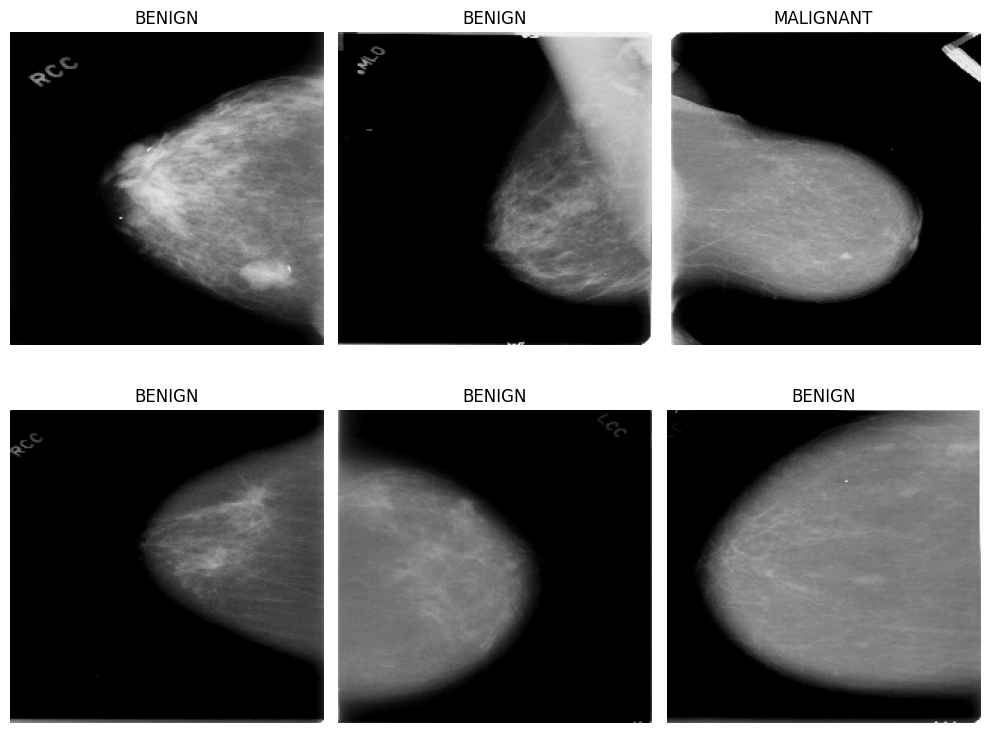

In [54]:
def display_images(images, titles, rows, cols, figsize=(10, 8)):
    """Display a grid of images with titles"""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display a sample of preprocessed images
sample_images = X_train[:6]  # Adjust the number of images to display
sample_labels = y_train[:6]  # Adjust labels accordingly

# Define titles for the images
class_names = ['BENIGN', 'MALIGNANT','BENIGN_WITHOUT_CALLBACK']  # Assuming 0 is benign and 1 is malignant
image_titles = [class_names[label] for label in sample_labels]

# Display the images
display_images(sample_images, image_titles, 2, 3)

In [55]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
import cv2
from skimage.filters import threshold_otsu
from skimage.restoration import wiener
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from skimage.restoration import wiener
from skimage.morphology import disk
#import pywt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [57]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l1_l2

In [58]:
# Define regularization parameters
l1_reg = 0.001
l2_reg = 0.001
dropout_rate = 0.3

# Add new classification layers with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout_rate)(x)  # Dropout layer to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model with new classification layers
model = Model(inputs=base_model.input, outputs=predictions)

In [59]:
#Adam
# Compile the model with initial learning rate
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [60]:
# Define a learning rate scheduler (if needed)
def lr_schedule(epoch):
    # Learning Rate Schedule
    lr = initial_learning_rate
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

In [61]:
from keras.callbacks import EarlyStopping

In [62]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint directory and file name
checkpoint_filepath = 'path/to/your/checkpoint_directory/model-{epoch:02d}-{val_accuracy:.2f}.weights.h5'

# Create a ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [63]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define training parameters
batch_size = 20
max_epochs = 50
num_iterations = 100

# Train the model with early stopping
#history = model.fit(X_train, y_train,
 #                   batch_size=batch_size,
  #                  epochs=max_epochs,
   #                 steps_per_epoch=num_iterations,
    #                validation_data=(X_test, y_test), 
     #               callbacks=[LearningRateScheduler(lr_schedule), early_stopping])


# Now, include the callback in your model.fit() call
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    steps_per_epoch=num_iterations,
                    validation_data=(X_test, y_test), 
                    callbacks=[LearningRateScheduler(lr_schedule), early_stopping, model_checkpoint_callback])

Epoch 1/50
 48/100 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.5493 - loss: 46.8826
Epoch 1: val_accuracy improved from -inf to 0.59367, saving model to path/to/your/checkpoint_directory/model-01-0.59.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 193ms/step - accuracy: 0.5712 - loss: 46.0579 - val_accuracy: 0.5937 - val_loss: 42.1367 - learning_rate: 1.0000e-04
Epoch 2/50
 48/100 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.7889 - loss: 40.2000
Epoch 2: val_accuracy did not improve from 0.59367
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.7922 - loss: 39.3952 - val_accuracy: 0.5766 - val_loss: 36.3087 - learning_rate: 1.0000e-04
Epoch 3/50
 48/100 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.9030 - loss: 33.8051
Epoch 3: val_accuracy improved from 0.59367 to 0.59854, saving model to path/to/your/checkpoint_directory/model-03-0.60.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.8942 - loss: 33.0676 - val_accuracy: 0.5985 - val_loss: 30.610

In [64]:
# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

In [65]:
# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

In [66]:
# Calculate overall training and validation loss and accuracy
overall_train_loss = np.mean(train_loss)
overall_train_accuracy = np.mean(train_accuracy)
overall_val_loss = np.mean(val_loss)
overall_val_accuracy = np.mean(val_accuracy)

# Print the overall accuracy
print("Overall Training Accuracy:", overall_train_accuracy)
print("Overall Validation Accuracy:", overall_val_accuracy)

Overall Training Accuracy: 0.9784117090702057
Overall Validation Accuracy: 0.7055961096286774


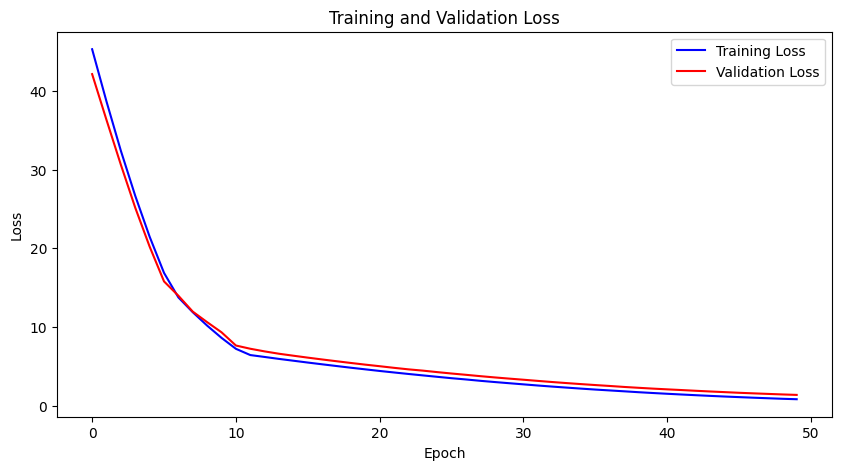

In [67]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

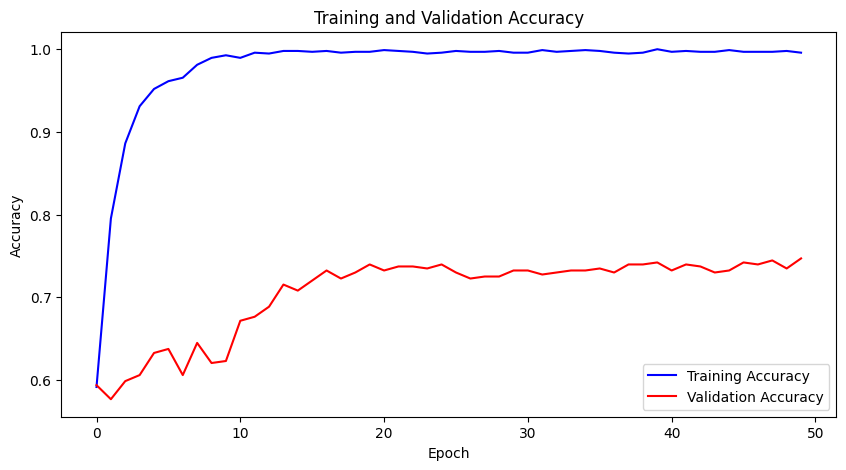

In [68]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [69]:
#'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0 , 
# Define label_to_class mapping
label_to_class = {
    0: ('BENIGN', 'BENIGN_WITHOUT_CALLBACK'),
    1: 'MALIGNANT',
    # Add more mappings as needed
}

# Function to decode predictions
def decode_predictions(predictions, threshold=0.5):
    decoded_labels = []
    for pred in predictions:
        decoded_labels.append([label_to_class[i] for i, p in enumerate(pred) if p >= threshold])
    return decoded_labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
True Class: MALIGNANT
Predicted Class: [[('BENIGN', 'BENIGN_WITHOUT_CALLBACK')]]


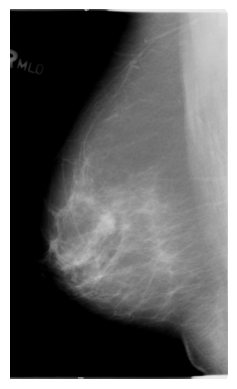

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
True Class: BENIGN
Predicted Class: [[('BENIGN', 'BENIGN_WITHOUT_CALLBACK')]]


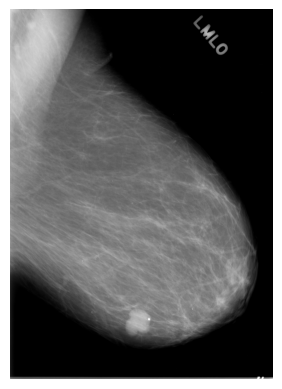

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
True Class: BENIGN_WITHOUT_CALLBACK
Predicted Class: [[]]


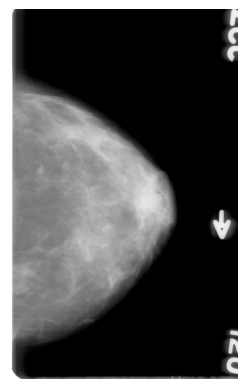

In [70]:
# Function to preprocess and load image
def preprocess_image(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to match model's input shape
    img = cv2.resize(img, (224, 224))
    # Normalize pixel values
    img = img.astype(np.float32) / 255.0
    # Convert to RGB color mode
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

# Select the first 5 images from mass_test_combined
test_images = full_mass_sample['image_file_path'].iloc[1:10]
true_classes = full_mass_sample['mass_margins'].iloc[1:10]

# Predict classes for each image
for image_path, true_class in zip(test_images, class_mapper):
    # Preprocess image
    img = preprocess_image(image_path)
    # Make prediction
    pred = model.predict(np.array([img]))
    predictions = decode_predictions(pred)
    # Print true and predicted classes
    print("True Class:", true_class)
    print("Predicted Class:", predictions)
    # Load and display the image
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [71]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step
Training Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       501
   MALIGNANT       1.00      1.00      1.00       456

    accuracy                           1.00       957
   macro avg       1.00      1.00      1.00       957
weighted avg       1.00      1.00      1.00       957



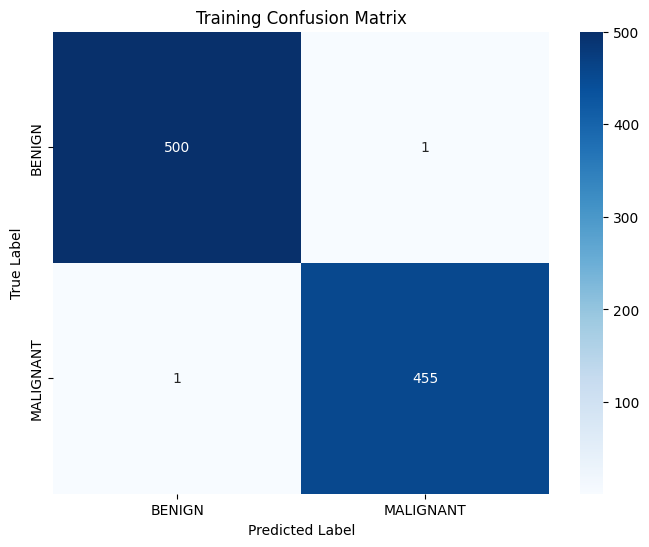

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Test Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.77      0.77      0.77       227
   MALIGNANT       0.72      0.72      0.72       184

    accuracy                           0.75       411
   macro avg       0.74      0.74      0.74       411
weighted avg       0.75      0.75      0.75       411



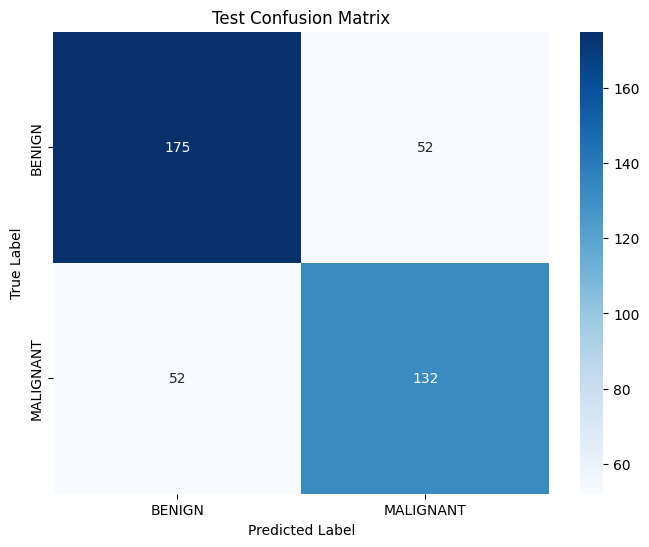

Overall Performance:
accuracy: 0.8724
recall: 0.8576
precision: 0.8576
f1: 0.8576


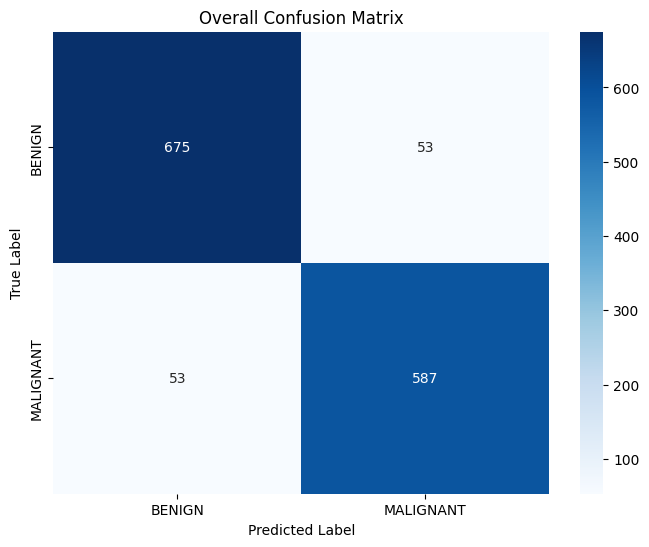

In [75]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, datasets):
    all_metrics = {}
    all_confusion_matrices = {}
    
    for dataset_type, (X_data, y_data) in datasets.items():
        y_pred = model.predict(X_data)

        # Convert predictions to binary (0 or 1)
        #y_pred_binary = np.argmax(y_pred, axis=1)
        y_pred_binary = (y_pred > 0.5).astype(int).flatten()
        #y_true_binary = np.argmax(y_data, axis=1)
        y_true_binary = y_data if y_data.ndim == 1 else np.argmax(y_data, axis=1)


        # Calculate metrics
        accuracy = accuracy_score(y_true_binary, y_pred_binary)
        recall = recall_score(y_true_binary, y_pred_binary)
        precision = precision_score(y_true_binary, y_pred_binary)
        f1 = f1_score(y_true_binary, y_pred_binary)
        confusion_mat = confusion_matrix(y_true_binary, y_pred_binary)
        
        all_metrics[dataset_type] = {'accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}
        all_confusion_matrices[dataset_type] = confusion_mat
        
        # Print classification report
        print(f"{dataset_type} Classification Report:")
        print(classification_report(y_true_binary, y_pred_binary, target_names=["BENIGN", "MALIGNANT"]))
        
        # Plot confusion matrix heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["BENIGN", "MALIGNANT"], yticklabels=["BENIGN", "MALIGNANT"])
        plt.title(f"{dataset_type} Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    
    # Aggregate confusion matrices for all datasets
    overall_confusion_matrix = sum(all_confusion_matrices.values())
    all_confusion_matrices["Overall"] = overall_confusion_matrix
    
    # Calculate overall performance metrics
    overall_performance = {}
    for metric_name in all_metrics["Training"].keys():
        overall_performance[metric_name] = np.mean([metrics[metric_name] for metrics in all_metrics.values()])
    
    # Print overall performance metrics
    print("Overall Performance:")
    for metric_name, value in overall_performance.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Plot overall confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(overall_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["BENIGN", "MALIGNANT"], yticklabels=["BENIGN", "MALIGNANT"])
    plt.title("Overall Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return all_metrics, all_confusion_matrices

# Usage example
datasets = {"Training": (X_train, y_train), 
            #"Validation": (X_val, y_val), 
            "Test": (X_test, y_test)}
all_metrics, all_confusion_matrices = evaluate_model(model, datasets)